# Uniswap Demo

## Introduction to Uniswap

>"Uniswap is an automated market maker for exchanging ERC20 tokens. Anyone can become a liquidity provider, and invest in the liquidity pool of an ERC20 token. This allows other users to trade that token for other tokens at an exchange rate based on their relative availibility. When a token trade is executed, a small fee is paid to the liquidity providers that enabled the transaction."

## Model File structure
* lab_notebook.ipynb
* model

In the model folder there exist 4 files and a parts folder, the [config.py](model/config.py), [partial_state_update_block.py](model/partial_state_update_block.py), [run.py](model/run.py), and [state_variables.py](state_variables.py). The [config.py](model/config.py) contains the simulation configurations, aggregating the partial states, and the state variables. The [partial_state_update_block.py](model/partial_state_update_block.py) contains the partial state update blocks and how they update the state variables. [state_variables.py](state_variables.py) defines the state variables and [run.py](model/run.py) actually runs the simulation. 

The components of the model live within the parts subfolder as:

* [system.py](model/parts/system.py)
* [utils.py](model/parts/utils.py)
* uniswap_events.pickle* 

The initial parameters and hyperparameters of the system are defined in [sys_params.py](model/sys_params.py) and helper functions, plots, etc. are in the [utils.py](model/parts/utils.py).


## Run Model

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))## Model File structure

# 04/Dec/2020 10:56

In [2]:
%%capture
# %matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
from model import run
from model.sys_params import sys_params
from model.state_variables import genesis_states
from model.partial_state_update_block import PSUBs
from cadCAD.configuration.utils import config_sim
from cadCAD.configuration import Experiment

To run the simulation, please insert your Nomics API key in the variable below. If you don't have, create one in t

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run(API_key=nomics_key)
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: multi_proc
Configuration Count: 1
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (147437, 6, 8, 4)
Execution Method: parallelize_simulations
Execution Mode: parallelized
Total execution time: 79.51s
Execution in 81.6s


In [4]:
fees = [(1-(param/1000))*100 for param in sys_params['fee_numerator']]
conv_tols = [param*100 for param in sys_params['conv_tolerance']]
c_rules = [param for param in sys_params['c_rule']]
conv_tols

[0.05, 2.5, 0.05, 2.5, 0.05, 2.5, 0.05, 2.5]

## Analysis

For information on how to access and analysis data from the Eth/Dai Uniswap smart contract, visit our sister notebook [here](Uniswap_EthDai_Exchange_Data.ipynb).


In this section, we will analyze how well our model compares to the actual data

In [10]:
model_history = experiments[['DAI_balance', 'ETH_balance', 'UNI_supply']]
model_history.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']

In [12]:
UNI_df = pd.read_pickle('./data/uniswap_events.pickle')
real_history = UNI_df.iloc[1:][['token_balance','eth_balance','UNI_supply']].reset_index(drop=True)
real_history.columns = ['real_DAI_balance', 'real_ETH_balance', 'real_UNI_supply']

Despite the simplifications, the outputs of the model are very similar to the real data

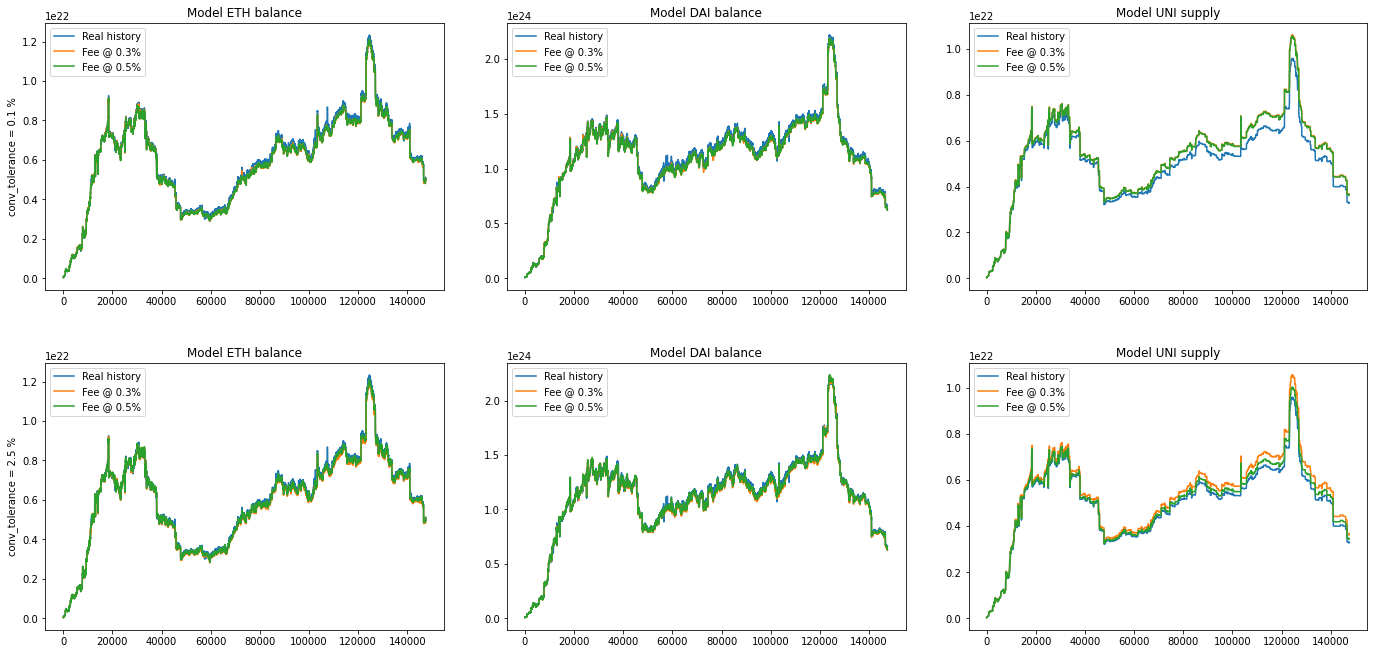

In [16]:
models = list()
for i in experiments['subset'].unique():
    models.append(experiments.loc[experiments['subset']==i,['DAI_balance', 'ETH_balance', 'UNI_supply']])
    
for df in models:
    df.columns = ['model_DAI_balance', 'model_ETH_balance', 'model_UNI_supply']
    df.reset_index(inplace=True)


nplots = len(set(fees))
nrows = len(set(conv_tols))
ncols = 3

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(20,10))

plt.close()

for i in range(nrows):
    axs[i][0].plot(real_history['real_ETH_balance'], label='Real history')
    axs[i][1].plot(real_history['real_DAI_balance'], label='Real history')
    axs[i][2].plot(real_history['real_UNI_supply'], label='Real history')
    axs[i][0].set_title('Model ETH balance')
    axs[i][1].set_title('Model DAI balance')
    axs[i][2].set_title('Model UNI supply')
    axs[i][0].set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[i]))
    
    for k in range(nplots):
        axs[i][0].plot(models[nplots*nrows*k + i]['model_ETH_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][1].plot(models[nplots*nrows*k + i]['model_DAI_balance'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))
        axs[i][2].plot(models[nplots*nrows*k + i]['model_UNI_supply'],
                       label='Fee @ {:.1f}%'.format(fees[nplots*nrows*k + i]))

    for j in range(ncols):
        axs[i][j].legend(loc='upper left')

fig.tight_layout(pad=4.0)
fig

In [17]:
df = experiments

prev_dai = pd.Series([np.nan]).append(df['DAI_balance'][:-1]).reset_index(drop=True)
prev_eth = pd.Series([np.nan]).append(df['ETH_balance'][:-1]).reset_index(drop=True)
df['delta_dai'] = df['DAI_balance'].diff()
df['delta_eth'] = df['ETH_balance'].diff()
df['istrade'] = (df['delta_dai'] > 0) != (df['delta_eth'] > 0)
df['volume'] = abs(df[df['istrade']]['delta_dai'])
df['volume'] = df['volume'].fillna(0)
df = df.drop(columns=['delta_dai','delta_eth','istrade'])

In [18]:
def ExpMovingAverage(values, window):
        weights = np.exp(np.linspace(-1., 0., window))
        weights /= weights.sum()
        a =  np.convolve(values, weights, mode='full')[:len(values)]
        a[:window] = a[window]
        return a

In [19]:
plot_data = experiments.copy()
plot_data[['DAI_balance',
           'ETH_balance',
           'UNI_supply',
           'volume']] = plot_data[['DAI_balance',
                                   'ETH_balance',
                                   'UNI_supply',
                                   'volume']]*1E-18
plot_data['ETH_price_DAI'] = plot_data['DAI_balance'] / plot_data['ETH_balance']
plot_data['UNI_price_DAI'] = 2 * plot_data['DAI_balance'] / plot_data['UNI_supply']

a = 0.5 * plot_data['ETH_price_DAI'][0] + 0.5 * plot_data['ETH_price_DAI']
plot_data['50_50_hodler_value'] = a.values

a = plot_data['50_50_hodler_value']/plot_data['50_50_hodler_value'][0] - 1
plot_data['50_50_hodler_return'] = a.values

a = plot_data['UNI_price_DAI']/plot_data['UNI_price_DAI'][0] - 1
plot_data['UNI_hodler_return'] = a.values

a = plot_data['ETH_price_DAI']/plot_data['ETH_price_DAI'][0] - 1
plot_data['ETH_hodler_return'] = a.values

plots = list()

for i in plot_data['subset'].unique():
    plots.append(plot_data[plot_data['subset'] == i])
for df in plots:
    df.reset_index(inplace=True)

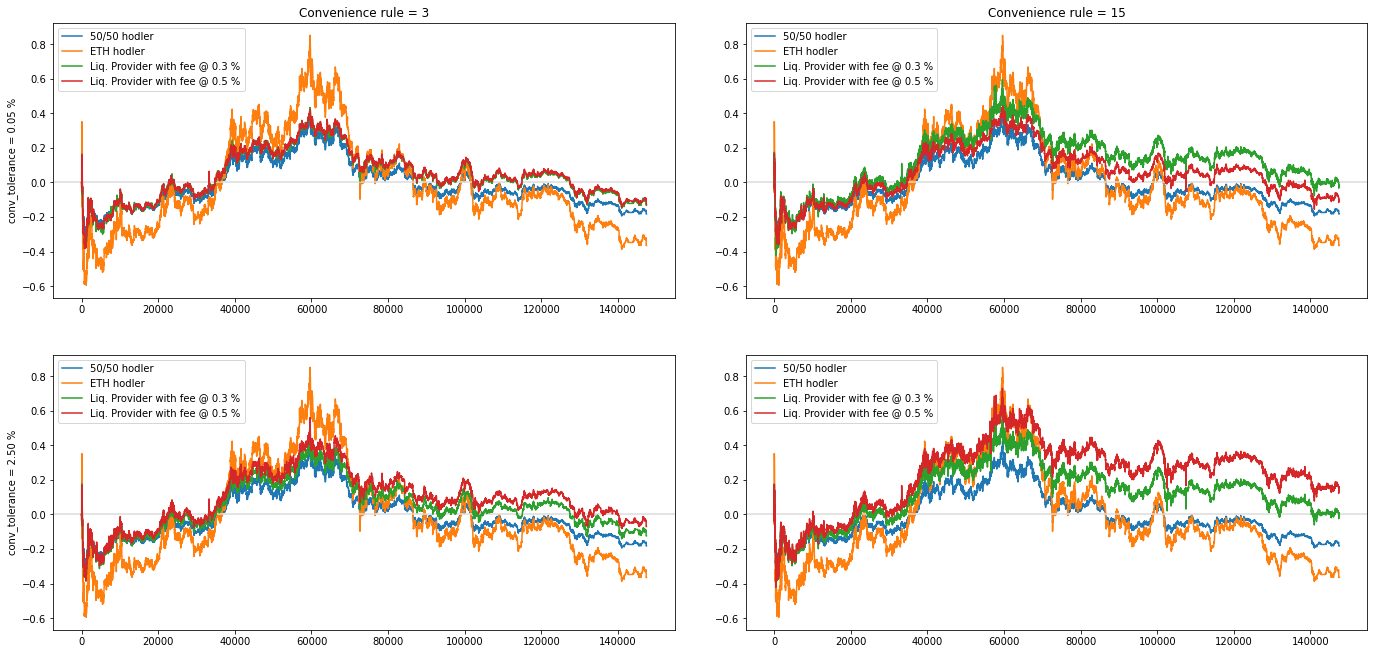

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation, rc
rc('animation', html='jshtml', embed_limit=50)
plt.rcParams['figure.facecolor'] = 'white'
from matplotlib import cm
import matplotlib.ticker as ticker

nplots = len(set(fees))
nrows = len(set(conv_tols))
ncols = len(set(c_rules))

fig, axs = plt.subplots(ncols = ncols, nrows = nrows, figsize=(ncols*10,nrows*5))

plt.close()

if nrows > 1:
    for i in range(nrows):
        if ncols > 1:
            for j in range(ncols):
                axs[i][j].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
                axs[i][j].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
                axs[i][j].axhline(0, color='gainsboro')
                axs[0][j].set_title(f'Convenience rule = {c_rules[ncols*j]}')
                axs[i][0].set_ylabel('conv_tolerance = {:.2f} %'.format(conv_tols[i]))
                for k in range(nplots):
                    ema = ExpMovingAverage(plots[nplots*nrows*k + ncols*j + i]['UNI_hodler_return'], 1)
                    axs[i][j].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nplots*nrows*k + ncols*j + i]))
            for j in range(ncols):
                axs[i][j].legend(loc='upper left')
        else:
            axs[i].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
            axs[i].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
            axs[i].axhline(0, color='gainsboro')
            axs[0].set_title(f'Convenience rule = {c_rules[0]}')
            axs[i].set_ylabel('conv_tolerance = {:.1f} %'.format(conv_tols[i])) 
            for k in range(nplots):
                ema = ExpMovingAverage(plots[nrows*k+i]['UNI_hodler_return'], 1)
                axs[i].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nrows*k+i]))
            axs[i].legend(loc='upper left')
            sec_ax = axs[i].twinx()
            sec_ax.set_yscale('log')
else:
    if ncols > 1:
        for i in range(ncols):
            axs[i].plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
            axs[i].plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
            axs[i].axhline(0, color='gainsboro')
            axs[0].set_title(f'Convenience rule = {c_rules[0]}')
            axs[i].set_ylabel('conv_tolerance = {:.2f} %'.format(conv_tols[i])) 
            for k in range(nplots):
                ema = ExpMovingAverage(plots[nrows*k+i]['UNI_hodler_return'], 1)
                axs[i].plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[nrows*k+i]))
            axs[i].legend(loc='upper left')
            sec_ax = axs[i].twinx()
            sec_ax.set_yscale('log')
    else:
        axs.plot(plots[0]['50_50_hodler_return'], label=f'50/50 hodler')
        axs.plot(plots[0]['ETH_hodler_return'], label=f'ETH hodler')
        axs.axhline(0, color='gainsboro')
        axs.set_title(f'Convenience rule = {c_rules[0]}')
        axs.set_ylabel('conv_tolerance = {:.2f} %'.format(conv_tols[0])) 
        for j in range(0, nplots):    
            ema = ExpMovingAverage(plots[j]['UNI_hodler_return'], 1)
            axs.plot(ema, label='Liq. Provider with fee @ {:.1f} %'.format(fees[j]))
        axs.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))
        axs.yaxis.tick_right()
        axs.legend(loc='upper left')
        axs.set_ylabel('conv_tolerance = {:.2f} %'.format(conv_tols[0]))
        sec_ax = axs.twinx()
        #     sec_ax.plot(plot_data.loc[i]['volume'], label='Volume')
        sec_ax.set_yscale('log')

fig.set_facecolor('white')
fig.tight_layout(pad=4.0)
fig

## Conclusion

In this notebook, we have illustrated how to create a cadCAD model that takes in real data and replicates the mechanics of a real world smart contract extremely acurately by translating the smart contract code into python code. We enforce best practices for cadCAD modeling, and analyze our simulation data against the real data. 